In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt

objp = np.zeros((6 * 9, 3), np.float32);
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2);

objpoints = []
imgpoints = []

calibration_image_files = glob.glob("../camera_cal/calibration*.jpg");

for idx, calibration_image_file in enumerate(calibration_image_files):
    
    img = cv2.imread(calibration_image_file);
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

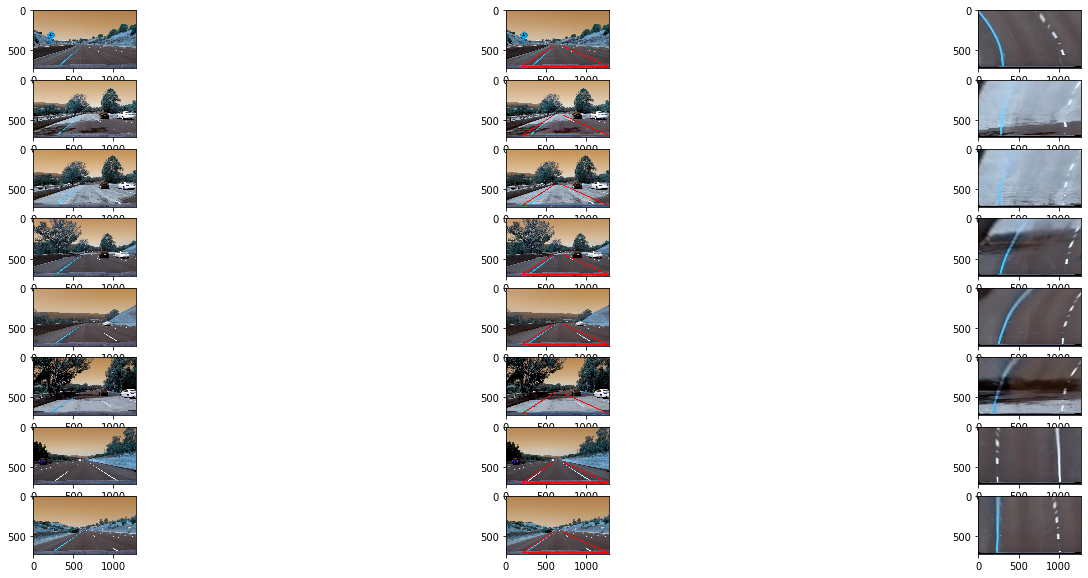

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

    if ret:
        undist = cv2.undistort(img, mtx, dist, None, mtx);
    else:
        undist = np.copy(img)

    return undist

#test_image_files = glob.glob("../test_images/straight_lines*.jpg");
test_image_files = glob.glob("../test_images/*.jpg");
num_files = len(test_image_files);

#figure = plt.figure(figsize=(24, 80))
figure = plt.figure(figsize=(24, 10))

undistorted_images = []
undistorted2_images = []

for idx, test_image_file in enumerate(test_image_files):

    img = cv2.imread(test_image_file)
    undistorted = cal_undistort(img, objpoints, imgpoints)

    plt.subplot(num_files, 3, 3 * (idx) + 1)
    plt.imshow(img)
    
    plt.subplot(num_files, 3, 3 * (idx) + 2)
    color = (255, 0, 0)
    pts = np.int32(
        [[715,  450],
         [1270, 700],
         [200,  700],
         [590,  450]])
    undistorted_rect = cv2.polylines(img, [pts],  False, color, 10);
    plt.imshow(undistorted_rect)
    
    #undistorted_images.append(undistorted)
    
    
    
    
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    src = np.float32(
        [[715,  450],
         [1270, 700],
         [200,  700],
         [590,  450]])
    
    dst = np.float32(
        [[1200, 100],
         [1200, 700],
         [200, 700],
         [200, 100]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    
    plt.subplot(num_files, 3, 3 * (idx) + 3)
    plt.imshow(warped)
    
    undistorted_images.append(warped)
    undistorted2_images.append(undistorted)

plt.show()

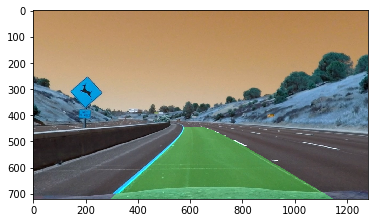

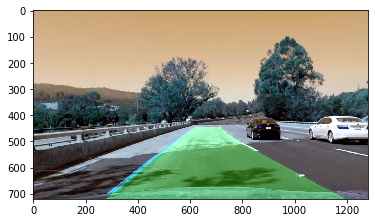

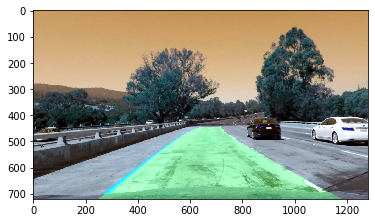

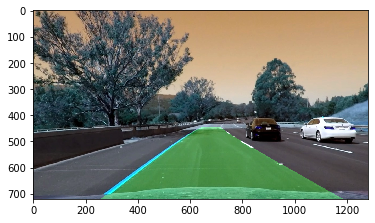

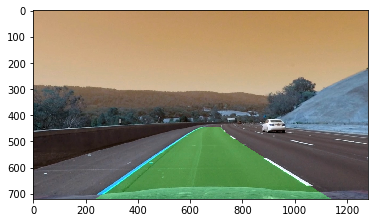

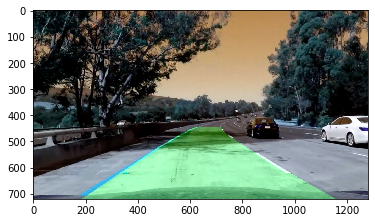

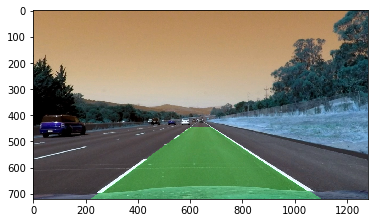

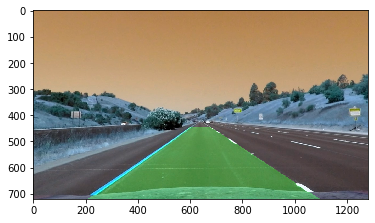

In [37]:
for idx, img in enumerate(undistorted_images):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plt.imshow(gray, cmap='gray')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Thresh
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #plt.imshow(combined_binary, cmap='gray')
    
    figure = plt.figure()
    #plt.imshow(combined_binary, cmap='gray')
    #plt.imshow(color_binary)
    
    bottom_half = combined_binary[combined_binary.shape[0] // 2:,:];
    histogram = np.sum(bottom_half, axis=0)
    #plt.plot(histogram)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    window_height = np.int(combined_binary.shape[0] // nwindows)
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    out_img = np.dstack((combined_binary * 255, combined_binary * 255, combined_binary * 255))
    
    
    
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    
        win_y_low = combined_binary.shape[0] - (window + 1) * window_height
        win_y_high = combined_binary.shape[0] - window * window_height
        
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0];
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0];
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    #plt.imshow(out_img)
    #print(leftx_base, rightx_base)
    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = left_fit
    right_fit_cr = right_fit
    #y_eval = np.max(720)
    y_eval = 720
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #print(left_curverad, right_curverad)
    
    
    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted2_images[idx]).astype(np.uint8)
    #print(warp_zero.shape)
    #color_warp = np.dstack((warp_zero))
    #print(color_warp.shape)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (combined_binary.shape[1], combined_binary.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted2_images[idx], 1, newwarp, 0.3, 0)
    plt.imshow(result)
    